In [137]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            ß=10,
            modified=True,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512 # args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


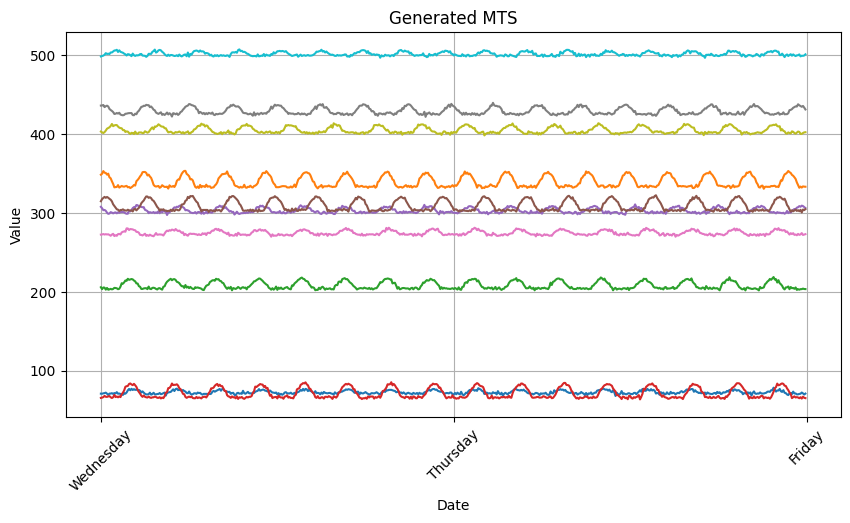

In [134]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="Seasonality",
                                                           occurance=1,
                                                           return_gen=True,
                                                           anomalies=False)

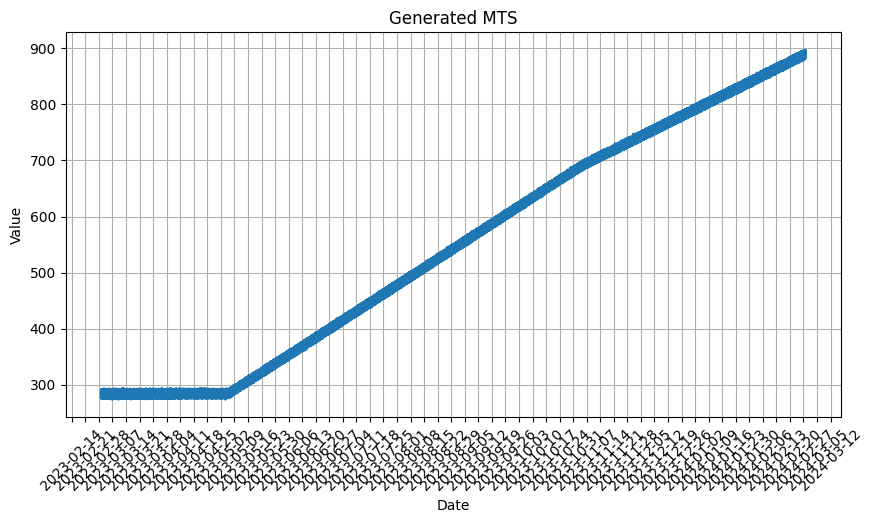

In [135]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [6]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [127]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
# labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [93]:
freqs = get_frequencies_per_week(vae, train_data, args, n=1)

In [128]:
labels.shape

torch.Size([1000, 2, 6, 4])

In [116]:
e_params["Seasonality"]["amplitude"][0]

array([8])

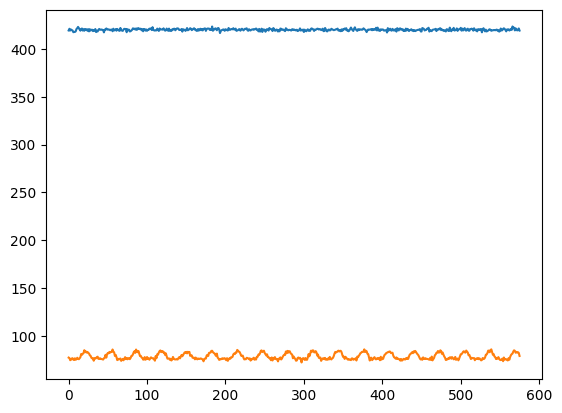

In [113]:
plt.plot(Origin_vae[0].T)

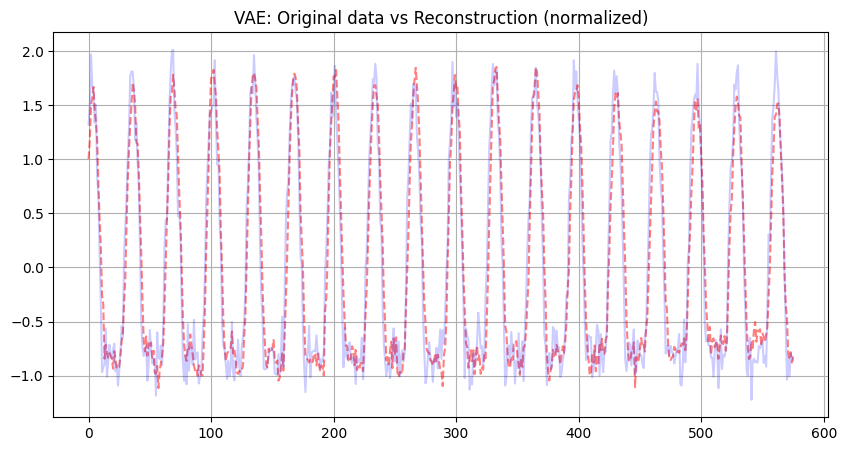

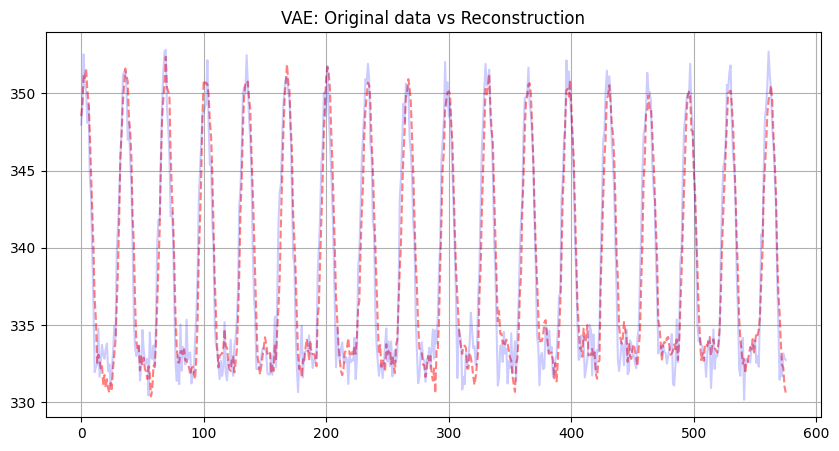

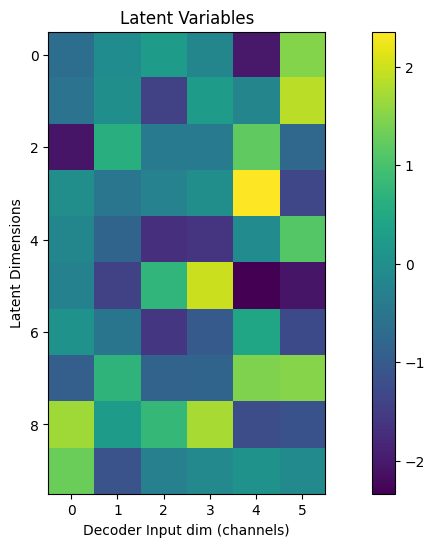

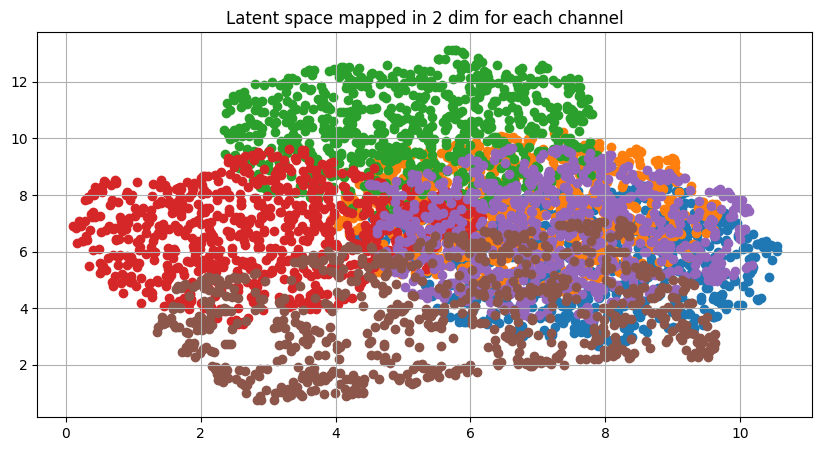

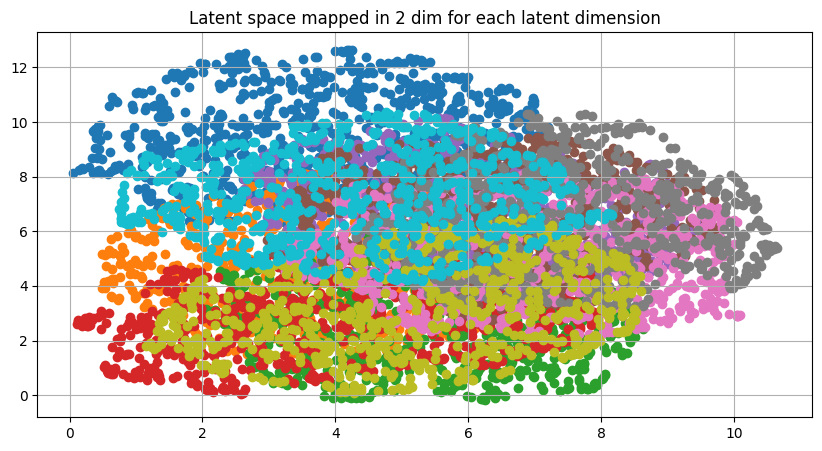

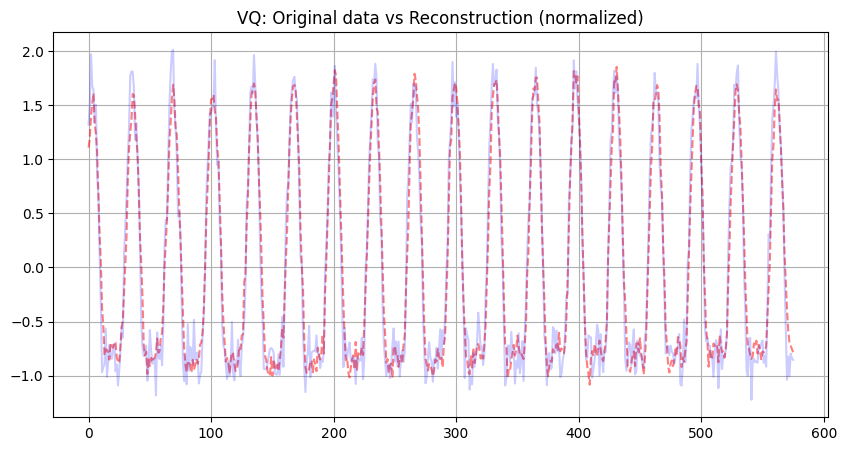

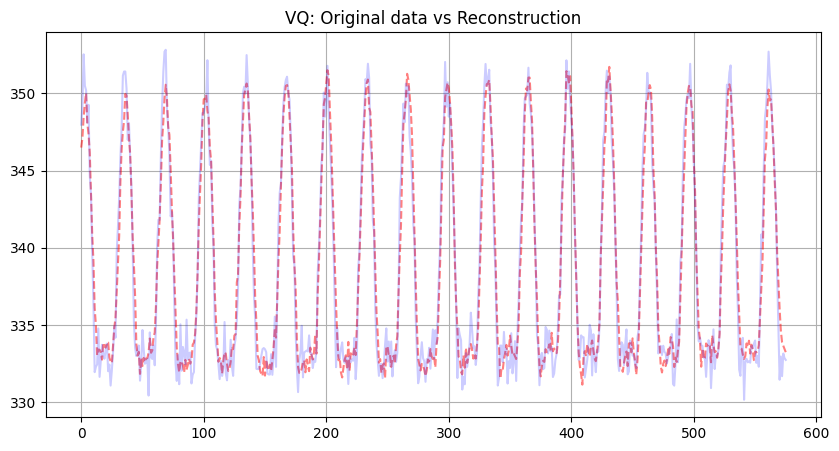

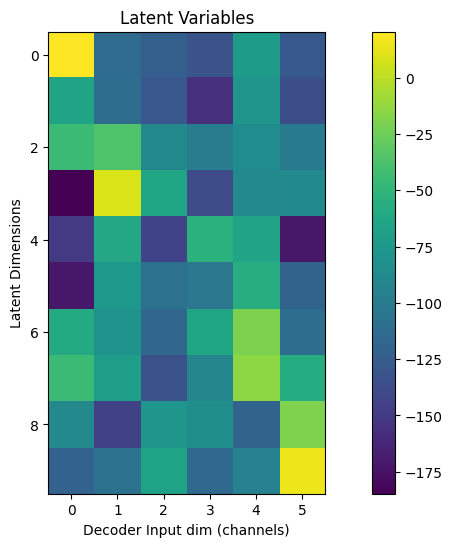

/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.w

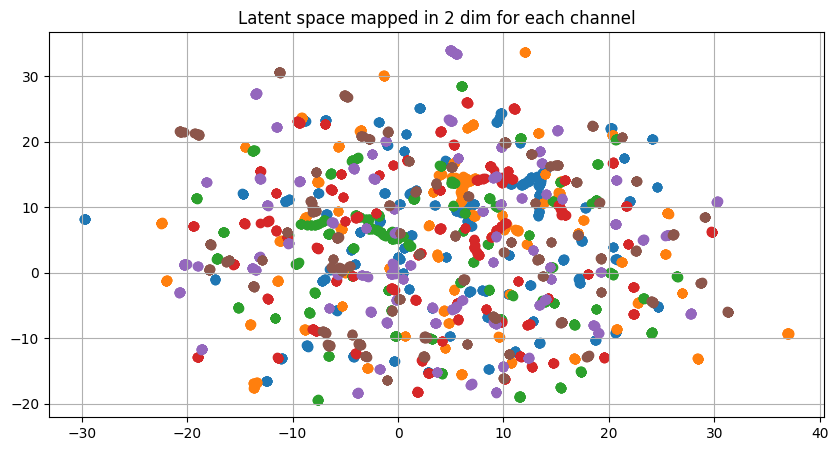

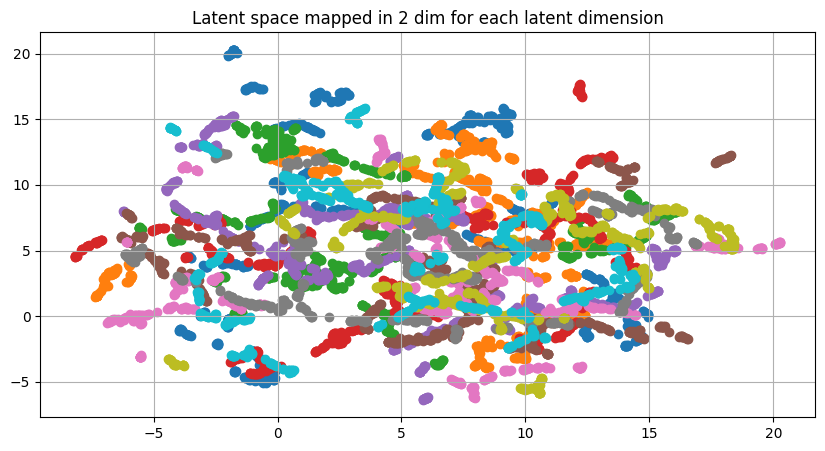

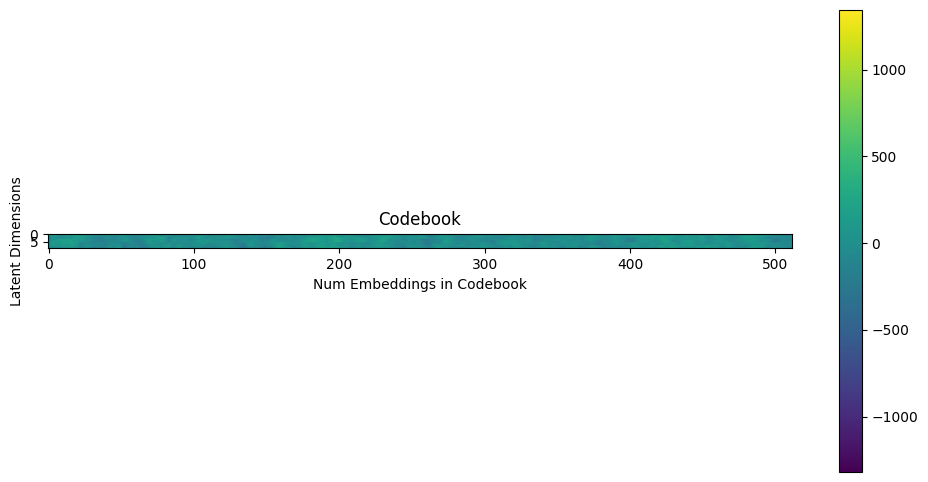

====> VAE: Sample 7001 Average loss: 0.1730
====> VQ: Sample 7001 Average loss: 0.1211
Train Epoch: 7002 [0/4 (0%)]	Loss: 137.220032	 True Loss: 35128.328125
Train Epoch: 7002 [0/4 (0%)]	Loss: 90.345711	 True Loss: 23128.501953
====> VAE: Sample 7002 Average loss: 0.1725
====> VQ: Sample 7002 Average loss: 0.1213
Train Epoch: 7003 [0/4 (0%)]	Loss: 138.250732	 True Loss: 35392.187500
Train Epoch: 7003 [0/4 (0%)]	Loss: 89.777145	 True Loss: 22982.949219
====> VAE: Sample 7003 Average loss: 0.1724
====> VQ: Sample 7003 Average loss: 0.1198
Train Epoch: 7004 [0/4 (0%)]	Loss: 139.332443	 True Loss: 35669.105469
Train Epoch: 7004 [0/4 (0%)]	Loss: 90.213623	 True Loss: 23094.687500
====> VAE: Sample 7004 Average loss: 0.1717
====> VQ: Sample 7004 Average loss: 0.1217
Train Epoch: 7005 [0/4 (0%)]	Loss: 137.965424	 True Loss: 35319.148438
Train Epoch: 7005 [0/4 (0%)]	Loss: 91.332237	 True Loss: 23381.052734
====> VAE: Sample 7005 Average loss: 0.1742
====> VQ: Sample 7005 Average loss: 0.1228
T

Train Epoch: 7038 [0/4 (0%)]	Loss: 140.474976	 True Loss: 35961.593750
Train Epoch: 7038 [0/4 (0%)]	Loss: 92.002243	 True Loss: 23552.574219
====> VAE: Sample 7038 Average loss: 0.1720
====> VQ: Sample 7038 Average loss: 0.1211
Train Epoch: 7039 [0/4 (0%)]	Loss: 136.544235	 True Loss: 34955.324219
Train Epoch: 7039 [0/4 (0%)]	Loss: 90.201263	 True Loss: 23091.523438
====> VAE: Sample 7039 Average loss: 0.1708
====> VQ: Sample 7039 Average loss: 0.1195
Train Epoch: 7040 [0/4 (0%)]	Loss: 139.298279	 True Loss: 35660.359375
Train Epoch: 7040 [0/4 (0%)]	Loss: 89.797913	 True Loss: 22988.265625
====> VAE: Sample 7040 Average loss: 0.1737
====> VQ: Sample 7040 Average loss: 0.1198
Train Epoch: 7041 [0/4 (0%)]	Loss: 137.885010	 True Loss: 35298.562500
Train Epoch: 7041 [0/4 (0%)]	Loss: 88.267334	 True Loss: 22596.437500
====> VAE: Sample 7041 Average loss: 0.1740
====> VQ: Sample 7041 Average loss: 0.1198
Train Epoch: 7042 [0/4 (0%)]	Loss: 141.393509	 True Loss: 36196.738281
Train Epoch: 7042

Train Epoch: 7074 [0/4 (0%)]	Loss: 139.172592	 True Loss: 35628.183594
Train Epoch: 7074 [0/4 (0%)]	Loss: 87.200745	 True Loss: 22323.390625
====> VAE: Sample 7074 Average loss: 0.1718
====> VQ: Sample 7074 Average loss: 0.1179
Train Epoch: 7075 [0/4 (0%)]	Loss: 139.153625	 True Loss: 35623.328125
Train Epoch: 7075 [0/4 (0%)]	Loss: 88.412186	 True Loss: 22633.519531
====> VAE: Sample 7075 Average loss: 0.1711
====> VQ: Sample 7075 Average loss: 0.1192
Train Epoch: 7076 [0/4 (0%)]	Loss: 137.832718	 True Loss: 35285.175781
Train Epoch: 7076 [0/4 (0%)]	Loss: 88.063599	 True Loss: 22544.281250
====> VAE: Sample 7076 Average loss: 0.1708
====> VQ: Sample 7076 Average loss: 0.1192
Train Epoch: 7077 [0/4 (0%)]	Loss: 137.990173	 True Loss: 35325.484375
Train Epoch: 7077 [0/4 (0%)]	Loss: 91.000351	 True Loss: 23296.089844
====> VAE: Sample 7077 Average loss: 0.1729
====> VQ: Sample 7077 Average loss: 0.1182
Train Epoch: 7078 [0/4 (0%)]	Loss: 138.671478	 True Loss: 35499.898438
Train Epoch: 7078

Train Epoch: 7110 [0/4 (0%)]	Loss: 139.278839	 True Loss: 35655.382812
Train Epoch: 7110 [0/4 (0%)]	Loss: 87.002167	 True Loss: 22272.554688
====> VAE: Sample 7110 Average loss: 0.1739
====> VQ: Sample 7110 Average loss: 0.1179
Train Epoch: 7111 [0/4 (0%)]	Loss: 140.201630	 True Loss: 35891.617188
Train Epoch: 7111 [0/4 (0%)]	Loss: 87.901825	 True Loss: 22502.867188
====> VAE: Sample 7111 Average loss: 0.1748
====> VQ: Sample 7111 Average loss: 0.1189
Train Epoch: 7112 [0/4 (0%)]	Loss: 138.881348	 True Loss: 35553.625000
Train Epoch: 7112 [0/4 (0%)]	Loss: 89.179871	 True Loss: 22830.046875
====> VAE: Sample 7112 Average loss: 0.1720
====> VQ: Sample 7112 Average loss: 0.1192
Train Epoch: 7113 [0/4 (0%)]	Loss: 138.536957	 True Loss: 35465.460938
Train Epoch: 7113 [0/4 (0%)]	Loss: 87.669960	 True Loss: 22443.509766
====> VAE: Sample 7113 Average loss: 0.1718
====> VQ: Sample 7113 Average loss: 0.1179
Train Epoch: 7114 [0/4 (0%)]	Loss: 138.500107	 True Loss: 35456.027344
Train Epoch: 7114

Train Epoch: 7146 [0/4 (0%)]	Loss: 137.023987	 True Loss: 35078.140625
Train Epoch: 7146 [0/4 (0%)]	Loss: 87.996727	 True Loss: 22527.162109
====> VAE: Sample 7146 Average loss: 0.1707
====> VQ: Sample 7146 Average loss: 0.1171
Train Epoch: 7147 [0/4 (0%)]	Loss: 139.558899	 True Loss: 35727.078125
Train Epoch: 7147 [0/4 (0%)]	Loss: 88.106171	 True Loss: 22555.179688
====> VAE: Sample 7147 Average loss: 0.1731
====> VQ: Sample 7147 Average loss: 0.1168
Train Epoch: 7148 [0/4 (0%)]	Loss: 139.450195	 True Loss: 35699.250000
Train Epoch: 7148 [0/4 (0%)]	Loss: 90.826340	 True Loss: 23251.542969
====> VAE: Sample 7148 Average loss: 0.1719
====> VQ: Sample 7148 Average loss: 0.1180
Train Epoch: 7149 [0/4 (0%)]	Loss: 138.072571	 True Loss: 35346.578125
Train Epoch: 7149 [0/4 (0%)]	Loss: 86.910362	 True Loss: 22249.052734
====> VAE: Sample 7149 Average loss: 0.1721
====> VQ: Sample 7149 Average loss: 0.1176
Train Epoch: 7150 [0/4 (0%)]	Loss: 139.207626	 True Loss: 35637.152344
Train Epoch: 7150

Train Epoch: 7182 [0/4 (0%)]	Loss: 139.440353	 True Loss: 35696.730469
Train Epoch: 7182 [0/4 (0%)]	Loss: 88.931526	 True Loss: 22766.470703
====> VAE: Sample 7182 Average loss: 0.1744
====> VQ: Sample 7182 Average loss: 0.1170
Train Epoch: 7183 [0/4 (0%)]	Loss: 136.522430	 True Loss: 34949.742188
Train Epoch: 7183 [0/4 (0%)]	Loss: 87.450882	 True Loss: 22387.425781
====> VAE: Sample 7183 Average loss: 0.1703
====> VQ: Sample 7183 Average loss: 0.1176
Train Epoch: 7184 [0/4 (0%)]	Loss: 142.316483	 True Loss: 36433.019531
Train Epoch: 7184 [0/4 (0%)]	Loss: 87.633369	 True Loss: 22434.142578
====> VAE: Sample 7184 Average loss: 0.1739
====> VQ: Sample 7184 Average loss: 0.1170
Train Epoch: 7185 [0/4 (0%)]	Loss: 137.253845	 True Loss: 35136.984375
Train Epoch: 7185 [0/4 (0%)]	Loss: 90.708710	 True Loss: 23221.429688
====> VAE: Sample 7185 Average loss: 0.1715
====> VQ: Sample 7185 Average loss: 0.1172
Train Epoch: 7186 [0/4 (0%)]	Loss: 139.136124	 True Loss: 35618.847656
Train Epoch: 7186

Train Epoch: 7218 [0/4 (0%)]	Loss: 140.863159	 True Loss: 36060.968750
Train Epoch: 7218 [0/4 (0%)]	Loss: 88.110519	 True Loss: 22556.292969
====> VAE: Sample 7218 Average loss: 0.1726
====> VQ: Sample 7218 Average loss: 0.1169
Train Epoch: 7219 [0/4 (0%)]	Loss: 138.438232	 True Loss: 35440.187500
Train Epoch: 7219 [0/4 (0%)]	Loss: 87.674789	 True Loss: 22444.746094
====> VAE: Sample 7219 Average loss: 0.1713
====> VQ: Sample 7219 Average loss: 0.1170
Train Epoch: 7220 [0/4 (0%)]	Loss: 138.118713	 True Loss: 35358.390625
Train Epoch: 7220 [0/4 (0%)]	Loss: 88.919403	 True Loss: 22763.367188
====> VAE: Sample 7220 Average loss: 0.1721
====> VQ: Sample 7220 Average loss: 0.1166
Train Epoch: 7221 [0/4 (0%)]	Loss: 138.319229	 True Loss: 35409.722656
Train Epoch: 7221 [0/4 (0%)]	Loss: 87.645256	 True Loss: 22437.185547
====> VAE: Sample 7221 Average loss: 0.1735
====> VQ: Sample 7221 Average loss: 0.1169
Train Epoch: 7222 [0/4 (0%)]	Loss: 138.089172	 True Loss: 35350.828125
Train Epoch: 7222

Train Epoch: 7254 [0/4 (0%)]	Loss: 86.264786	 True Loss: 22083.785156
====> VAE: Sample 7254 Average loss: 0.1710
====> VQ: Sample 7254 Average loss: 0.1154
Train Epoch: 7255 [0/4 (0%)]	Loss: 139.833282	 True Loss: 35797.320312
Train Epoch: 7255 [0/4 (0%)]	Loss: 87.618881	 True Loss: 22430.433594
====> VAE: Sample 7255 Average loss: 0.1717
====> VQ: Sample 7255 Average loss: 0.1164
Train Epoch: 7256 [0/4 (0%)]	Loss: 136.789688	 True Loss: 35018.160156
Train Epoch: 7256 [0/4 (0%)]	Loss: 88.481796	 True Loss: 22651.339844
====> VAE: Sample 7256 Average loss: 0.1721
====> VQ: Sample 7256 Average loss: 0.1164
Train Epoch: 7257 [0/4 (0%)]	Loss: 139.930664	 True Loss: 35822.250000
Train Epoch: 7257 [0/4 (0%)]	Loss: 87.923058	 True Loss: 22508.302734
====> VAE: Sample 7257 Average loss: 0.1729
====> VQ: Sample 7257 Average loss: 0.1163
Train Epoch: 7258 [0/4 (0%)]	Loss: 139.943390	 True Loss: 35825.507812
Train Epoch: 7258 [0/4 (0%)]	Loss: 87.019691	 True Loss: 22277.041016
====> VAE: Sample 

Train Epoch: 7290 [0/4 (0%)]	Loss: 88.453934	 True Loss: 22644.207031
====> VAE: Sample 7290 Average loss: 0.1725
====> VQ: Sample 7290 Average loss: 0.1172
Train Epoch: 7291 [0/4 (0%)]	Loss: 137.527603	 True Loss: 35207.066406
Train Epoch: 7291 [0/4 (0%)]	Loss: 87.712402	 True Loss: 22454.375000
====> VAE: Sample 7291 Average loss: 0.1723
====> VQ: Sample 7291 Average loss: 0.1162
Train Epoch: 7292 [0/4 (0%)]	Loss: 137.991425	 True Loss: 35325.804688
Train Epoch: 7292 [0/4 (0%)]	Loss: 86.534882	 True Loss: 22152.929688
====> VAE: Sample 7292 Average loss: 0.1720
====> VQ: Sample 7292 Average loss: 0.1156
Train Epoch: 7293 [0/4 (0%)]	Loss: 139.883377	 True Loss: 35810.144531
Train Epoch: 7293 [0/4 (0%)]	Loss: 87.750870	 True Loss: 22464.222656
====> VAE: Sample 7293 Average loss: 0.1725
====> VQ: Sample 7293 Average loss: 0.1176
Train Epoch: 7294 [0/4 (0%)]	Loss: 143.208954	 True Loss: 36661.492188
Train Epoch: 7294 [0/4 (0%)]	Loss: 86.347336	 True Loss: 22104.917969
====> VAE: Sample 

Train Epoch: 7326 [0/4 (0%)]	Loss: 88.331963	 True Loss: 22612.982422
====> VAE: Sample 7326 Average loss: 0.1710
====> VQ: Sample 7326 Average loss: 0.1166
Train Epoch: 7327 [0/4 (0%)]	Loss: 136.268677	 True Loss: 34884.781250
Train Epoch: 7327 [0/4 (0%)]	Loss: 89.353119	 True Loss: 22874.398438
====> VAE: Sample 7327 Average loss: 0.1711
====> VQ: Sample 7327 Average loss: 0.1179
Train Epoch: 7328 [0/4 (0%)]	Loss: 136.790848	 True Loss: 35018.457031
Train Epoch: 7328 [0/4 (0%)]	Loss: 86.767075	 True Loss: 22212.371094
====> VAE: Sample 7328 Average loss: 0.1703
====> VQ: Sample 7328 Average loss: 0.1148
Train Epoch: 7329 [0/4 (0%)]	Loss: 138.784042	 True Loss: 35528.714844
Train Epoch: 7329 [0/4 (0%)]	Loss: 86.412308	 True Loss: 22121.550781
====> VAE: Sample 7329 Average loss: 0.1716
====> VQ: Sample 7329 Average loss: 0.1156
Train Epoch: 7330 [0/4 (0%)]	Loss: 138.164368	 True Loss: 35370.078125
Train Epoch: 7330 [0/4 (0%)]	Loss: 87.775658	 True Loss: 22470.568359
====> VAE: Sample 

Train Epoch: 7362 [0/4 (0%)]	Loss: 85.304993	 True Loss: 21838.078125
====> VAE: Sample 7362 Average loss: 0.1733
====> VQ: Sample 7362 Average loss: 0.1142
Train Epoch: 7363 [0/4 (0%)]	Loss: 139.973297	 True Loss: 35833.164062
Train Epoch: 7363 [0/4 (0%)]	Loss: 87.702126	 True Loss: 22451.744141
====> VAE: Sample 7363 Average loss: 0.1729
====> VQ: Sample 7363 Average loss: 0.1162
Train Epoch: 7364 [0/4 (0%)]	Loss: 139.484543	 True Loss: 35708.042969
Train Epoch: 7364 [0/4 (0%)]	Loss: 89.476151	 True Loss: 22905.894531
====> VAE: Sample 7364 Average loss: 0.1718
====> VQ: Sample 7364 Average loss: 0.1166
Train Epoch: 7365 [0/4 (0%)]	Loss: 138.076843	 True Loss: 35347.671875
Train Epoch: 7365 [0/4 (0%)]	Loss: 86.554443	 True Loss: 22157.937500
====> VAE: Sample 7365 Average loss: 0.1720
====> VQ: Sample 7365 Average loss: 0.1154
Train Epoch: 7366 [0/4 (0%)]	Loss: 140.172363	 True Loss: 35884.125000
Train Epoch: 7366 [0/4 (0%)]	Loss: 89.843185	 True Loss: 22999.855469
====> VAE: Sample 

Train Epoch: 7398 [0/4 (0%)]	Loss: 86.797401	 True Loss: 22220.134766
====> VAE: Sample 7398 Average loss: 0.1711
====> VQ: Sample 7398 Average loss: 0.1158
Train Epoch: 7399 [0/4 (0%)]	Loss: 140.614960	 True Loss: 35997.429688
Train Epoch: 7399 [0/4 (0%)]	Loss: 86.321327	 True Loss: 22098.259766
====> VAE: Sample 7399 Average loss: 0.1729
====> VQ: Sample 7399 Average loss: 0.1146
Train Epoch: 7400 [0/4 (0%)]	Loss: 136.678986	 True Loss: 34989.820312
Train Epoch: 7400 [0/4 (0%)]	Loss: 87.046112	 True Loss: 22283.804688
====> VAE: Sample 7400 Average loss: 0.1707
====> VQ: Sample 7400 Average loss: 0.1147
Train Epoch: 7401 [0/4 (0%)]	Loss: 140.371460	 True Loss: 35935.093750
Train Epoch: 7401 [0/4 (0%)]	Loss: 89.626366	 True Loss: 22944.349609
====> VAE: Sample 7401 Average loss: 0.1725
====> VQ: Sample 7401 Average loss: 0.1162
Train Epoch: 7402 [0/4 (0%)]	Loss: 137.204498	 True Loss: 35124.351562
Train Epoch: 7402 [0/4 (0%)]	Loss: 86.819931	 True Loss: 22225.902344
====> VAE: Sample 

Train Epoch: 7434 [0/4 (0%)]	Loss: 86.636223	 True Loss: 22178.873047
====> VAE: Sample 7434 Average loss: 0.1737
====> VQ: Sample 7434 Average loss: 0.1145
Train Epoch: 7435 [0/4 (0%)]	Loss: 139.293457	 True Loss: 35659.125000
Train Epoch: 7435 [0/4 (0%)]	Loss: 86.829956	 True Loss: 22228.468750
====> VAE: Sample 7435 Average loss: 0.1711
====> VQ: Sample 7435 Average loss: 0.1150
Train Epoch: 7436 [0/4 (0%)]	Loss: 138.536957	 True Loss: 35465.460938
Train Epoch: 7436 [0/4 (0%)]	Loss: 84.209671	 True Loss: 21557.675781
====> VAE: Sample 7436 Average loss: 0.1722
====> VQ: Sample 7436 Average loss: 0.1142
Train Epoch: 7437 [0/4 (0%)]	Loss: 136.487061	 True Loss: 34940.687500
Train Epoch: 7437 [0/4 (0%)]	Loss: 85.730026	 True Loss: 21946.886719
====> VAE: Sample 7437 Average loss: 0.1698
====> VQ: Sample 7437 Average loss: 0.1152
Train Epoch: 7438 [0/4 (0%)]	Loss: 141.343933	 True Loss: 36184.046875
Train Epoch: 7438 [0/4 (0%)]	Loss: 86.047287	 True Loss: 22028.105469
====> VAE: Sample 

Train Epoch: 7470 [0/4 (0%)]	Loss: 86.664436	 True Loss: 22186.095703
====> VAE: Sample 7470 Average loss: 0.1719
====> VQ: Sample 7470 Average loss: 0.1159
Train Epoch: 7471 [0/4 (0%)]	Loss: 139.947998	 True Loss: 35826.687500
Train Epoch: 7471 [0/4 (0%)]	Loss: 85.384804	 True Loss: 21858.509766
====> VAE: Sample 7471 Average loss: 0.1738
====> VQ: Sample 7471 Average loss: 0.1140
Train Epoch: 7472 [0/4 (0%)]	Loss: 138.735168	 True Loss: 35516.203125
Train Epoch: 7472 [0/4 (0%)]	Loss: 87.244339	 True Loss: 22334.550781
====> VAE: Sample 7472 Average loss: 0.1740
====> VQ: Sample 7472 Average loss: 0.1151
Train Epoch: 7473 [0/4 (0%)]	Loss: 137.155457	 True Loss: 35111.796875
Train Epoch: 7473 [0/4 (0%)]	Loss: 86.294884	 True Loss: 22091.490234
====> VAE: Sample 7473 Average loss: 0.1704
====> VQ: Sample 7473 Average loss: 0.1152
Train Epoch: 7474 [0/4 (0%)]	Loss: 140.462128	 True Loss: 35958.304688
Train Epoch: 7474 [0/4 (0%)]	Loss: 85.458916	 True Loss: 21877.482422
====> VAE: Sample 

Train Epoch: 7506 [0/4 (0%)]	Loss: 87.704697	 True Loss: 22452.402344
====> VAE: Sample 7506 Average loss: 0.1713
====> VQ: Sample 7506 Average loss: 0.1161
Train Epoch: 7507 [0/4 (0%)]	Loss: 136.517532	 True Loss: 34948.488281
Train Epoch: 7507 [0/4 (0%)]	Loss: 87.574799	 True Loss: 22419.148438
====> VAE: Sample 7507 Average loss: 0.1700
====> VQ: Sample 7507 Average loss: 0.1150
Train Epoch: 7508 [0/4 (0%)]	Loss: 139.876663	 True Loss: 35808.425781
Train Epoch: 7508 [0/4 (0%)]	Loss: 83.660706	 True Loss: 21417.140625
====> VAE: Sample 7508 Average loss: 0.1731
====> VQ: Sample 7508 Average loss: 0.1137
Train Epoch: 7509 [0/4 (0%)]	Loss: 138.484222	 True Loss: 35451.960938
Train Epoch: 7509 [0/4 (0%)]	Loss: 84.805786	 True Loss: 21710.281250
====> VAE: Sample 7509 Average loss: 0.1724
====> VQ: Sample 7509 Average loss: 0.1128
Train Epoch: 7510 [0/4 (0%)]	Loss: 139.388947	 True Loss: 35683.570312
Train Epoch: 7510 [0/4 (0%)]	Loss: 85.262260	 True Loss: 21827.138672
====> VAE: Sample 

Train Epoch: 7542 [0/4 (0%)]	Loss: 86.067970	 True Loss: 22033.400391
====> VAE: Sample 7542 Average loss: 0.1744
====> VQ: Sample 7542 Average loss: 0.1152
Train Epoch: 7543 [0/4 (0%)]	Loss: 135.969238	 True Loss: 34808.125000
Train Epoch: 7543 [0/4 (0%)]	Loss: 87.632668	 True Loss: 22433.962891
====> VAE: Sample 7543 Average loss: 0.1714
====> VQ: Sample 7543 Average loss: 0.1149
Train Epoch: 7544 [0/4 (0%)]	Loss: 137.361328	 True Loss: 35164.500000
Train Epoch: 7544 [0/4 (0%)]	Loss: 86.460648	 True Loss: 22133.925781
====> VAE: Sample 7544 Average loss: 0.1711
====> VQ: Sample 7544 Average loss: 0.1153
Train Epoch: 7545 [0/4 (0%)]	Loss: 140.184113	 True Loss: 35887.132812
Train Epoch: 7545 [0/4 (0%)]	Loss: 86.615036	 True Loss: 22173.449219
====> VAE: Sample 7545 Average loss: 0.1739
====> VQ: Sample 7545 Average loss: 0.1145
Train Epoch: 7546 [0/4 (0%)]	Loss: 136.497559	 True Loss: 34943.375000
Train Epoch: 7546 [0/4 (0%)]	Loss: 88.769943	 True Loss: 22725.105469
====> VAE: Sample 

Train Epoch: 7578 [0/4 (0%)]	Loss: 87.031281	 True Loss: 22280.007812
====> VAE: Sample 7578 Average loss: 0.1724
====> VQ: Sample 7578 Average loss: 0.1153
Train Epoch: 7579 [0/4 (0%)]	Loss: 139.856003	 True Loss: 35803.136719
Train Epoch: 7579 [0/4 (0%)]	Loss: 86.499817	 True Loss: 22143.953125
====> VAE: Sample 7579 Average loss: 0.1732
====> VQ: Sample 7579 Average loss: 0.1146
Train Epoch: 7580 [0/4 (0%)]	Loss: 136.419571	 True Loss: 34923.410156
Train Epoch: 7580 [0/4 (0%)]	Loss: 89.039787	 True Loss: 22794.185547
====> VAE: Sample 7580 Average loss: 0.1713
====> VQ: Sample 7580 Average loss: 0.1163
Train Epoch: 7581 [0/4 (0%)]	Loss: 139.752625	 True Loss: 35776.671875
Train Epoch: 7581 [0/4 (0%)]	Loss: 88.469894	 True Loss: 22648.292969
====> VAE: Sample 7581 Average loss: 0.1724
====> VQ: Sample 7581 Average loss: 0.1152
Train Epoch: 7582 [0/4 (0%)]	Loss: 141.149536	 True Loss: 36134.281250
Train Epoch: 7582 [0/4 (0%)]	Loss: 87.029671	 True Loss: 22279.595703
====> VAE: Sample 

Train Epoch: 7614 [0/4 (0%)]	Loss: 87.634155	 True Loss: 22434.343750
====> VAE: Sample 7614 Average loss: 0.1718
====> VQ: Sample 7614 Average loss: 0.1160
Train Epoch: 7615 [0/4 (0%)]	Loss: 139.555481	 True Loss: 35726.203125
Train Epoch: 7615 [0/4 (0%)]	Loss: 87.102425	 True Loss: 22298.220703
====> VAE: Sample 7615 Average loss: 0.1709
====> VQ: Sample 7615 Average loss: 0.1153
Train Epoch: 7616 [0/4 (0%)]	Loss: 139.047287	 True Loss: 35596.105469
Train Epoch: 7616 [0/4 (0%)]	Loss: 87.749023	 True Loss: 22463.750000
====> VAE: Sample 7616 Average loss: 0.1728
====> VQ: Sample 7616 Average loss: 0.1152
Train Epoch: 7617 [0/4 (0%)]	Loss: 137.812271	 True Loss: 35279.941406
Train Epoch: 7617 [0/4 (0%)]	Loss: 88.731247	 True Loss: 22715.199219
====> VAE: Sample 7617 Average loss: 0.1717
====> VQ: Sample 7617 Average loss: 0.1161
Train Epoch: 7618 [0/4 (0%)]	Loss: 138.245575	 True Loss: 35390.867188
Train Epoch: 7618 [0/4 (0%)]	Loss: 87.286575	 True Loss: 22345.363281
====> VAE: Sample 

Train Epoch: 7650 [0/4 (0%)]	Loss: 87.152466	 True Loss: 22311.031250
====> VAE: Sample 7650 Average loss: 0.1732
====> VQ: Sample 7650 Average loss: 0.1154
Train Epoch: 7651 [0/4 (0%)]	Loss: 136.170181	 True Loss: 34859.566406
Train Epoch: 7651 [0/4 (0%)]	Loss: 87.475563	 True Loss: 22393.744141
====> VAE: Sample 7651 Average loss: 0.1710
====> VQ: Sample 7651 Average loss: 0.1141
Train Epoch: 7652 [0/4 (0%)]	Loss: 139.266235	 True Loss: 35652.156250
Train Epoch: 7652 [0/4 (0%)]	Loss: 85.193062	 True Loss: 21809.423828
====> VAE: Sample 7652 Average loss: 0.1724
====> VQ: Sample 7652 Average loss: 0.1152
Train Epoch: 7653 [0/4 (0%)]	Loss: 137.935760	 True Loss: 35311.554688
Train Epoch: 7653 [0/4 (0%)]	Loss: 86.447586	 True Loss: 22130.582031
====> VAE: Sample 7653 Average loss: 0.1731
====> VQ: Sample 7653 Average loss: 0.1155
Train Epoch: 7654 [0/4 (0%)]	Loss: 136.840805	 True Loss: 35031.246094
Train Epoch: 7654 [0/4 (0%)]	Loss: 87.006538	 True Loss: 22273.673828
====> VAE: Sample 

Train Epoch: 7686 [0/4 (0%)]	Loss: 84.639595	 True Loss: 21667.736328
====> VAE: Sample 7686 Average loss: 0.1718
====> VQ: Sample 7686 Average loss: 0.1128
Train Epoch: 7687 [0/4 (0%)]	Loss: 138.737885	 True Loss: 35516.898438
Train Epoch: 7687 [0/4 (0%)]	Loss: 88.521523	 True Loss: 22661.509766
====> VAE: Sample 7687 Average loss: 0.1725
====> VQ: Sample 7687 Average loss: 0.1156
Train Epoch: 7688 [0/4 (0%)]	Loss: 144.319641	 True Loss: 36945.828125
Train Epoch: 7688 [0/4 (0%)]	Loss: 86.369415	 True Loss: 22110.570312
====> VAE: Sample 7688 Average loss: 0.1731
====> VQ: Sample 7688 Average loss: 0.1143
Train Epoch: 7689 [0/4 (0%)]	Loss: 138.837708	 True Loss: 35542.453125
Train Epoch: 7689 [0/4 (0%)]	Loss: 85.070503	 True Loss: 21778.048828
====> VAE: Sample 7689 Average loss: 0.1717
====> VQ: Sample 7689 Average loss: 0.1142
Train Epoch: 7690 [0/4 (0%)]	Loss: 138.783279	 True Loss: 35528.519531
Train Epoch: 7690 [0/4 (0%)]	Loss: 85.542679	 True Loss: 21898.925781
====> VAE: Sample 

====> VAE: Sample 7722 Average loss: 0.1688
====> VQ: Sample 7722 Average loss: 0.1161
Train Epoch: 7723 [0/4 (0%)]	Loss: 137.427475	 True Loss: 35181.433594
Train Epoch: 7723 [0/4 (0%)]	Loss: 89.547546	 True Loss: 22924.171875
====> VAE: Sample 7723 Average loss: 0.1729
====> VQ: Sample 7723 Average loss: 0.1162
Train Epoch: 7724 [0/4 (0%)]	Loss: 139.423065	 True Loss: 35692.304688
Train Epoch: 7724 [0/4 (0%)]	Loss: 86.842270	 True Loss: 22231.621094
====> VAE: Sample 7724 Average loss: 0.1724
====> VQ: Sample 7724 Average loss: 0.1167
Train Epoch: 7725 [0/4 (0%)]	Loss: 143.764709	 True Loss: 36803.765625
Train Epoch: 7725 [0/4 (0%)]	Loss: 89.206757	 True Loss: 22836.929688
====> VAE: Sample 7725 Average loss: 0.1745
====> VQ: Sample 7725 Average loss: 0.1173
Train Epoch: 7726 [0/4 (0%)]	Loss: 140.094299	 True Loss: 35864.140625
Train Epoch: 7726 [0/4 (0%)]	Loss: 88.532814	 True Loss: 22664.400391
====> VAE: Sample 7726 Average loss: 0.1725
====> VQ: Sample 7726 Average loss: 0.1161
T

Train Epoch: 7759 [0/4 (0%)]	Loss: 87.438644	 True Loss: 22384.292969
====> VAE: Sample 7759 Average loss: 0.1710
====> VQ: Sample 7759 Average loss: 0.1153
Train Epoch: 7760 [0/4 (0%)]	Loss: 138.947021	 True Loss: 35570.437500
Train Epoch: 7760 [0/4 (0%)]	Loss: 87.058846	 True Loss: 22287.064453
====> VAE: Sample 7760 Average loss: 0.1725
====> VQ: Sample 7760 Average loss: 0.1157
Train Epoch: 7761 [0/4 (0%)]	Loss: 137.148285	 True Loss: 35109.960938
Train Epoch: 7761 [0/4 (0%)]	Loss: 87.571022	 True Loss: 22418.181641
====> VAE: Sample 7761 Average loss: 0.1708
====> VQ: Sample 7761 Average loss: 0.1149
Train Epoch: 7762 [0/4 (0%)]	Loss: 138.493774	 True Loss: 35454.406250
Train Epoch: 7762 [0/4 (0%)]	Loss: 86.854904	 True Loss: 22234.855469
====> VAE: Sample 7762 Average loss: 0.1709
====> VQ: Sample 7762 Average loss: 0.1146
Train Epoch: 7763 [0/4 (0%)]	Loss: 138.021332	 True Loss: 35333.460938
Train Epoch: 7763 [0/4 (0%)]	Loss: 88.673767	 True Loss: 22700.484375
====> VAE: Sample 

Train Epoch: 7795 [0/4 (0%)]	Loss: 89.639053	 True Loss: 22947.597656
====> VAE: Sample 7795 Average loss: 0.1746
====> VQ: Sample 7795 Average loss: 0.1169
Train Epoch: 7796 [0/4 (0%)]	Loss: 138.799011	 True Loss: 35532.546875
Train Epoch: 7796 [0/4 (0%)]	Loss: 87.384888	 True Loss: 22370.531250
====> VAE: Sample 7796 Average loss: 0.1723
====> VQ: Sample 7796 Average loss: 0.1144
Train Epoch: 7797 [0/4 (0%)]	Loss: 136.878326	 True Loss: 35040.851562
Train Epoch: 7797 [0/4 (0%)]	Loss: 86.769890	 True Loss: 22213.091797
====> VAE: Sample 7797 Average loss: 0.1719
====> VQ: Sample 7797 Average loss: 0.1146
Train Epoch: 7798 [0/4 (0%)]	Loss: 139.238953	 True Loss: 35645.171875
Train Epoch: 7798 [0/4 (0%)]	Loss: 86.774620	 True Loss: 22214.302734
====> VAE: Sample 7798 Average loss: 0.1732
====> VQ: Sample 7798 Average loss: 0.1156
Train Epoch: 7799 [0/4 (0%)]	Loss: 137.106277	 True Loss: 35099.207031
Train Epoch: 7799 [0/4 (0%)]	Loss: 86.278091	 True Loss: 22087.191406
====> VAE: Sample 

Train Epoch: 7831 [0/4 (0%)]	Loss: 86.846268	 True Loss: 22232.644531
====> VAE: Sample 7831 Average loss: 0.1704
====> VQ: Sample 7831 Average loss: 0.1172
Train Epoch: 7832 [0/4 (0%)]	Loss: 139.622559	 True Loss: 35743.375000
Train Epoch: 7832 [0/4 (0%)]	Loss: 88.895668	 True Loss: 22757.291016
====> VAE: Sample 7832 Average loss: 0.1721
====> VQ: Sample 7832 Average loss: 0.1180
Train Epoch: 7833 [0/4 (0%)]	Loss: 136.201050	 True Loss: 34867.468750
Train Epoch: 7833 [0/4 (0%)]	Loss: 88.155884	 True Loss: 22567.906250
====> VAE: Sample 7833 Average loss: 0.1724
====> VQ: Sample 7833 Average loss: 0.1171
Train Epoch: 7834 [0/4 (0%)]	Loss: 135.302872	 True Loss: 34637.535156
Train Epoch: 7834 [0/4 (0%)]	Loss: 89.640411	 True Loss: 22947.945312
====> VAE: Sample 7834 Average loss: 0.1711
====> VQ: Sample 7834 Average loss: 0.1187
Train Epoch: 7835 [0/4 (0%)]	Loss: 138.366104	 True Loss: 35421.722656
Train Epoch: 7835 [0/4 (0%)]	Loss: 91.088013	 True Loss: 23318.531250
====> VAE: Sample 

Train Epoch: 7867 [0/4 (0%)]	Loss: 86.530891	 True Loss: 22151.908203
====> VAE: Sample 7867 Average loss: 0.1729
====> VQ: Sample 7867 Average loss: 0.1145
Train Epoch: 7868 [0/4 (0%)]	Loss: 137.859711	 True Loss: 35292.085938
Train Epoch: 7868 [0/4 (0%)]	Loss: 86.978683	 True Loss: 22266.542969
====> VAE: Sample 7868 Average loss: 0.1718
====> VQ: Sample 7868 Average loss: 0.1147
Train Epoch: 7869 [0/4 (0%)]	Loss: 138.974197	 True Loss: 35577.394531
Train Epoch: 7869 [0/4 (0%)]	Loss: 87.650787	 True Loss: 22438.601562
====> VAE: Sample 7869 Average loss: 0.1725
====> VQ: Sample 7869 Average loss: 0.1148
Train Epoch: 7870 [0/4 (0%)]	Loss: 136.000290	 True Loss: 34816.074219
Train Epoch: 7870 [0/4 (0%)]	Loss: 88.602386	 True Loss: 22682.210938
====> VAE: Sample 7870 Average loss: 0.1702
====> VQ: Sample 7870 Average loss: 0.1157
Train Epoch: 7871 [0/4 (0%)]	Loss: 138.002472	 True Loss: 35328.632812
Train Epoch: 7871 [0/4 (0%)]	Loss: 85.709923	 True Loss: 21941.740234
====> VAE: Sample 

In [141]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 10000):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%1000 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args)
        show_results(vq, train_data, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [129]:
from torch.nn.functional import normalize

class identifier(nn.Module):
    def __init__(self, args, n_layers, output_size):
        super(identifier, self).__init__()   
        
        self.n_channels =  args.n_channels      
        self.slope = args.slope
        self.n_layers = n_layers
        self.input_size = args.enc_out * args.latent_dims
        self.output_size = output_size
        self.lin_layers = nn.ModuleList()
#         self.n = 1
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
                m.bias.data.fill_(0.01)
                
        # Linear Layers
        for i in range(0, n_layers):
            
            if i == self.n_layers -1:
                self.lin_layers.append(nn.Linear(self.input_size, self.output_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
            else:
                self.lin_layers.append(nn.Linear(self.input_size, self.input_size))
                self.lin_layers.append(nn.LeakyReLU(self.slope, True))
#                 self.lin_layers.append(nn.BatchNorm1d(self.n))
        
        self.lin_layers.apply(init_weights)
            
         
    def forward(self, x):
#         print("x input", x.shape)
#         x_shape = x.shape
        x = x.view(x.size(0), -1)
#         print("x before lin", x.shape)
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)        
#         print("x after lin", x.shape)
#         print("x out", x.shape)
#         x = x.view(x.shape[0], -1, self.n_channels)
        return x

def train_identifier_modified(model, id_model, train_loader, optimizer, args, epoch):
    
    device=args.device
    labels_size = id_model.output_size
    n_channels = args.n_channels
    
    id_model.train()
    for p in id_model.parameters():
        p.requires_grad = True
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    train_loss = 0
    y_pred = torch.empty((0, 2*labels_size//n_channels), device=device)
    for batch_idx, (data_tup, label, norm) in enumerate(train_loader):
#         print(data.shape)
        data_tup = [data.to(device) for data in data_tup]
        data = pick_data(data_tup, args)
        norm = [n.to(device) for n in norm]
        bs   = data.shape[0]  
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        label_pred = id_model(e)

        optimizer.zero_grad()

        label = normalize(label, p=1, dim=0).to(device)
        loss = F.mse_loss(label_pred, label[...,1], reduction='mean')

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        y_pred = torch.cat((y_pred, label_pred), dim = 0) 
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return y_pred


In [130]:
id_mlp_vae = identifier(args=args, n_layers=1, output_size=3)
id_mlp_vq = identifier(args=args, n_layers=1, output_size=3)

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.01)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.01)

In [131]:
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)

/tmp/ipykernel_29193/185131394.py:74: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(label_pred, label[...,1], reduction='mean')


RuntimeError: The size of tensor a (3) must match the size of tensor b (256) at non-singleton dimension 1

In [30]:
pred_mlp = id_mlp_vae(X_train_vae)
pred_mlp[0]

NameError: name 'X_train_vae' is not defined

In [207]:
id_mlp_vae.lin_layers[0].weight.shape

torch.Size([10, 120])

In [49]:
def extract_id_data(model, train_loader, args, norm=True):
    device=args.device
    labels_size = 12
    n_channels = args.n_channels

    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    X = torch.empty((0, args.enc_out, args.latent_dims), device = device) 
    Y = torch.empty((0, labels_size//n_channels), device=device)

    for batch_idx, (data_tup, label, norm) in enumerate(train_loader):

        data = pick_data(data_tup, args)
        norm = [n.to(device) for n in norm]
        bs   = data.shape[0]  
        label = label.to(device)
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        
        # Save X and y 
        X = torch.cat((X, e), dim=0)
        Y = torch.cat((Y, label[...,1]), dim=0)
        
    # Reshape and normalize
    X = X.view(X.shape[0], -1)
    if norm:
        X = normalize(X, p=1, dim=0)
        Y = normalize(Y, p=1, dim=0)

    return X.cpu().detach(), Y.cpu().detach()

In [50]:
X_train_vae, y_train_vae = extract_id_data(vae, train_data, args)
X_train_vq, y_train_vq = extract_id_data(vq, train_data, args)

In [51]:
X_train_vae.shape

torch.Size([800, 8])

In [52]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

id_lasso_vae = linear_model.Lasso(alpha=0.1, max_iter=10000)
id_lasso_vq = linear_model.Lasso(alpha=0.5)

id_forest_vae = RandomForestRegressor(n_estimators=10)
id_forest_vq = RandomForestRegressor(n_estimators=10)

id_lasso_vae.fit(X_train_vae, y_train_vae)
id_lasso_vq.fit(X_train_vq, y_train_vq)

id_forest_vae.fit(X_train_vae, y_train_vae)
id_forest_vq.fit(X_train_vq, y_train_vq)

# Lasso(alpha=0.1)

/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/kadran1/testenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor(n_estimators=10)

In [53]:
pred = id_lasso_vae.predict(X_train_vae)

In [54]:
pred.shape

(800, 6)

In [55]:
pred[0]

array([0.00125, 0.00125, 0.00125, 0.00125, 0.00125, 0.00125])

In [56]:
y_train_vae[0]

tensor([0.0013, 0.0012, 0.0010, 0.0002, 0.0005, 0.0017])

In [72]:
# rf = randomForest(Species~.,data=iris,ntree=200,mtry=2,sampsize=30,keep.forest=TRUE,replace=FALSE,keep.inbag=TRUE)

# out_vars = varUsed(rf,by.tree=TRUE) # gives the variables used in each tree
# apply(out_vars,2,function(x) which(x!=0))

# out_case = rf$inbag # gives the cases used in each tree
# apply(out_case,2,function(x) which(x!=0))
def get_R_from_forest(X, y, n_estimators=10):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X, y_values) 

        # Get feature importances for this y value
        feature_importances = rf_model.feature_importances_
        R.append(feature_importances)
        
    return np.array(R).T

In [77]:
R_mlp_vae = id_mlp_vae.lin_layers[0].weight.detach().cpu().numpy()
R_mlp_vq = id_mlp_vq.lin_layers[0].weight.detach().cpu().numpy()
R_lasso_vae = id_lasso_vae.coef_
R_lasso_vq = id_lasso_vq.coef_
R_forest_vae = get_R_from_forest(X_train_vae, y_train_vae)
R_forest_vq = get_R_from_forest(X_train_vq, y_train_vq)

Rs = [R_mlp_vae, R_mlp_vq, R_lasso_vae, R_lasso_vq, R_forest_vae, R_forest_vq]

In [78]:
def calc_P_matrix(R):
    # Calculate the denominator: PK-1 Rik for each row
    denominator = np.sum(R, axis=1)

    # Ensure there are no division by zero errors
    denominator[denominator == 0] = 1

    # Calculate the P matrix using broadcasting
    P = R / denominator[:, np.newaxis]

    return P

def calc_H(P):

    # Calculate the entropy formula using broadcasting
    K = P.shape[1]
    H = -np.sum(P * np.log(K) * P, axis=1)
#     print(H.shape)

    return H
def calc_D(H):
    return 1-H

def hinton(matrix, max_weight=None, ax=None):
    if ax is None:
        ax = plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

    # Add labels to the axes
    ax.set_xticks(np.arange(matrix.shape[0]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_xticklabels(range(1, matrix.shape[0] + 1))
    ax.set_yticklabels(range(1, matrix.shape[1] + 1))
    plt.xlabel('Vector 2 Index')
    plt.ylabel('Vector 1 Index')

def hinton_diagram(R):
    Pi = calc_P_matrix(R.T)
    Pj = calc_P_matrix(R)

    Hd = calc_H(Pi)
    Hc = calc_H(Pj)
    
    D = calc_D(Hd)
    C = calc_D(Hc)

    diagram = D[:, np.newaxis] * C
    plt.figure(figsize=(6, 8))
    hinton(diagram.T)
    plt.show()


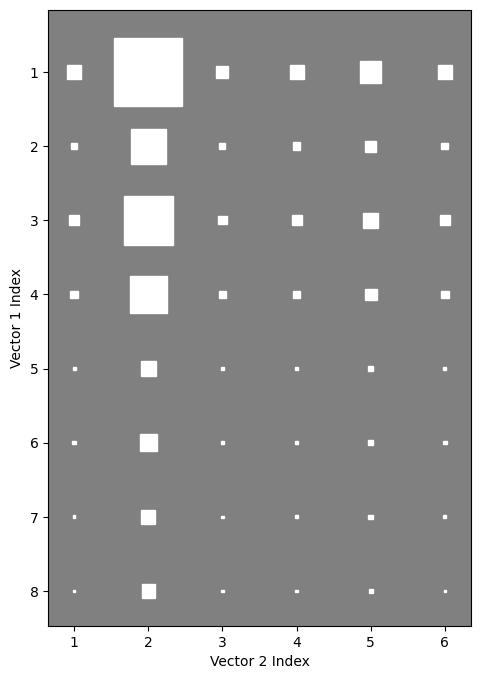

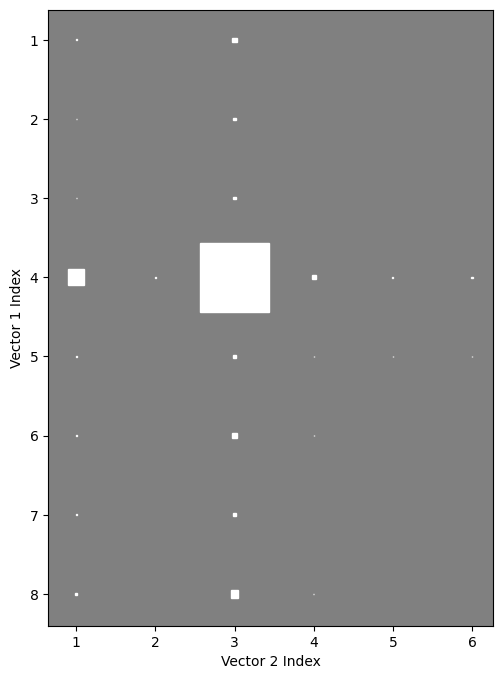

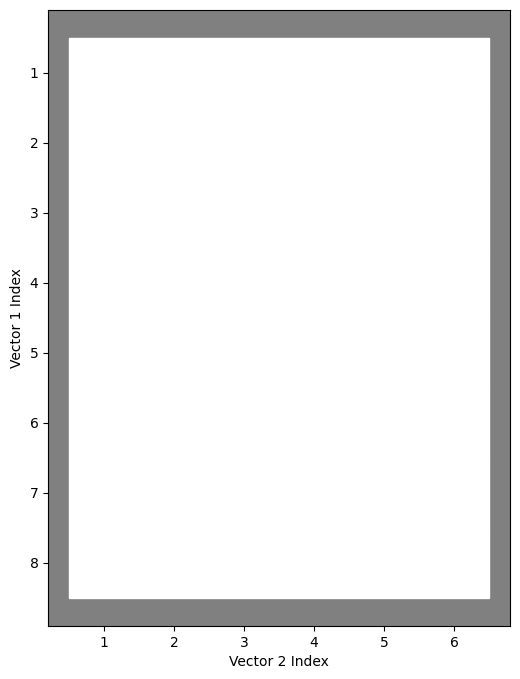

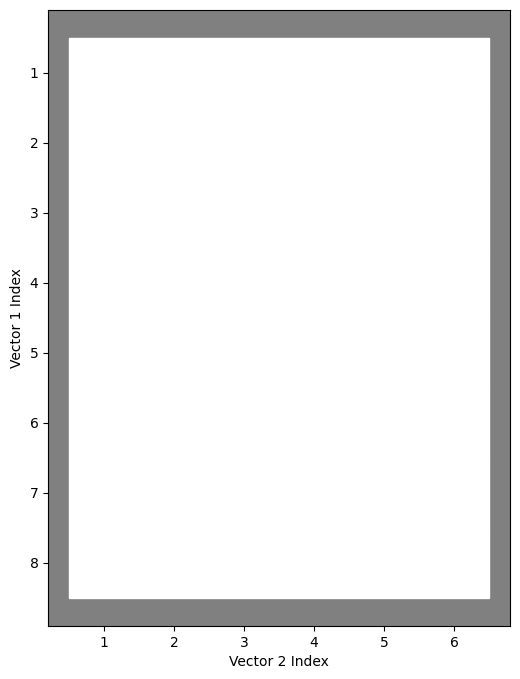

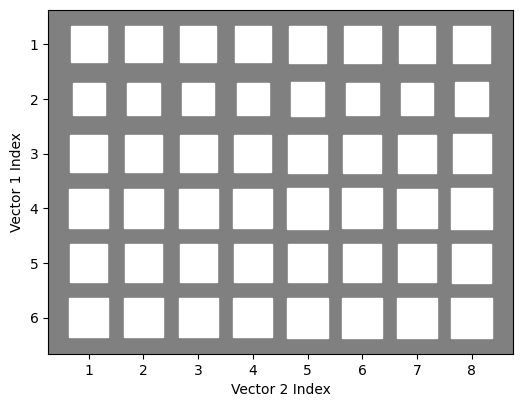

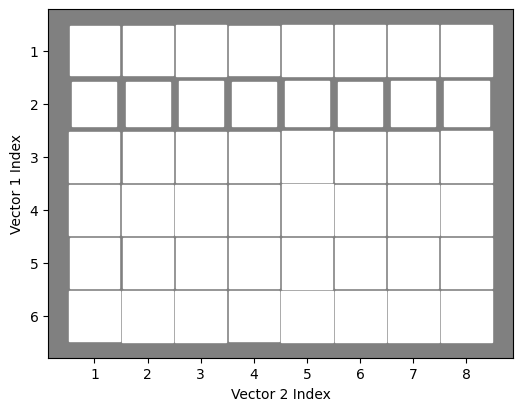

In [79]:
for R in Rs:
    hinton_diagram(R)

In [28]:
Origin, REC, latents = rebuild_TS(vq, train_data, args)
latents.shape

torch.Size([800, 2, 10])

In [30]:
latents_reshaped = latents.reshape(-1, args.latent_dims)

In [29]:
umap_result = []
for i in range(args.n_channels):
    latent_grp = latents[:,i,:]
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(latent_grp)
    umap_result.append(embedding)


/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [31]:
import umap
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(latents_reshaped)


/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


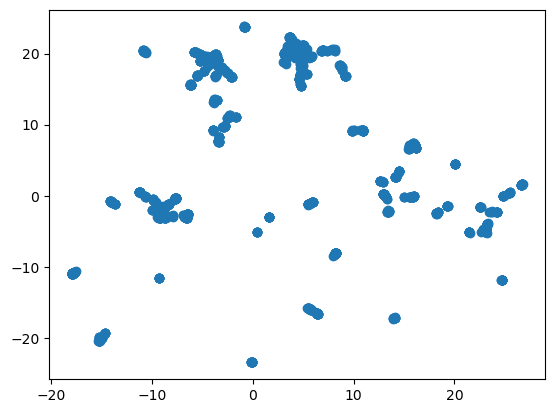

In [32]:
plt.scatter(umap_result[:,0], umap_result[:,1])

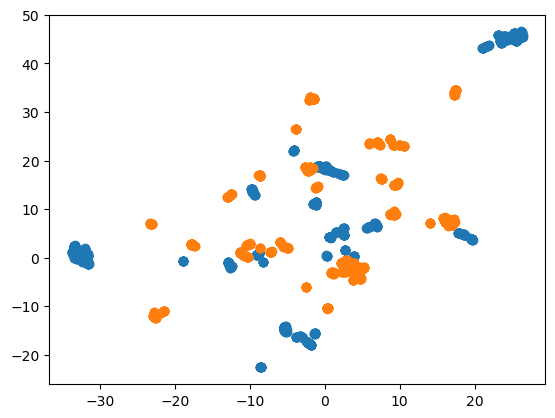

In [26]:
for embed in umap_result:
    plt.scatter(embed[:,0], embed[:,1])

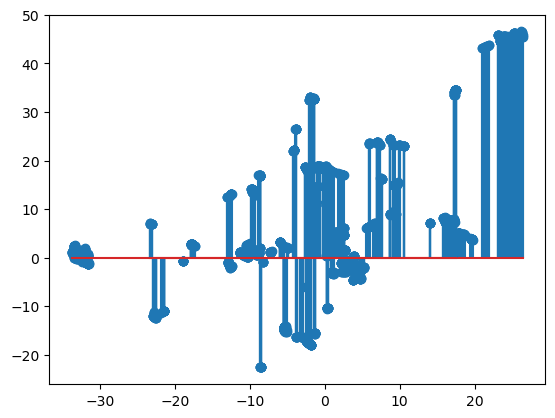

In [27]:
for embed in umap_result:
    plt.stem(embed[:,0], embed[:,1].T)

In [ ]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[i, 0].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 0].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[i, 0].set_title(titles[i])
        ax[i, 0].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[i, 1].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[i, 1].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[i, 1].set_title(titles[i])
        ax[i, 1].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()